Let's first import the libraries we need for running the show

In [ ]:
#Source Code: https://github.com/dynamicslab/deep-learning-fluids

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Any machine learning problem starts with data! If you have a machine learning idea in mind, first look for the data. If it's hard to get, you might want to change your mind. The more data the better, especially if you planning to use neural networks.

In this problem we will generate the data instead of collecting it. This is not uncommon in some applications like physics constrained learning. Sometimes, you already have a predictor but you want to make it faster, so you create a surrogate model using machine learning to make fast predictions.

We'll generate 100 data points for a parabolic function $y = x^2$. We'll add some "measurement noise" to mimic real-world data and explore the concepts of over- and under-fitting.

In [2]:
# Generate data
noise_strength = 10 
x = np.linspace(0, 10, 100)
y = x**2 + noise_strength * (np.random.random((len(x)))-0.5)

Now we can split the data into training, validation and test sets. The training set is used to optimize the model and find the optimal weights $\hat{\mathbf w}$, the validation set is used to test the generalization error while trying different hyperparameters and models, and the test set is finally used to evaluate your final generalization error.

The validation set is sometimes called a "dev" set.

In [3]:
test_size = 0.2 # Partion of data in test set
shuffle = False # Whether to sample anywhere in domain of x or separate training and testing domains

# Split data into train/dev/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=shuffle)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=test_size, shuffle=shuffle)


Note that I'm not shuffling the data to highlight the idea of extrapolation. This is common with time series data where the purpose of a machine learning model is to predict the future. This is illustrated in the visualization below. You'll see how over-fitting doesn't do well on extrapolation.

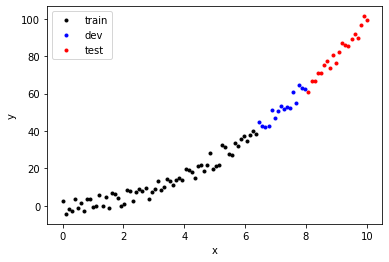

In [4]:
# Visualize the data
fig = plt.figure()
plt.plot(x_train, y_train, 'k.')
plt.plot(x_dev, y_dev, 'b.')
plt.plot(x_test, y_test, 'r.')
plt.legend(['train', 'dev', 'test'])
plt.ylabel('y')
plt.xlabel('x')
plt.show()

Once you visualize the data try to get an intuition on the trends, you're ready to design your feature vector. We'll define a function that takes the data $x$ as an input and transforms it into a matrix containing polynomial features. The first column is contain the bias because $x^0 = 1$, and the $i+1$-st column will have the data for $x^i$. 

Let's define that function

In [5]:
def make_features(x, degree=1):
    X = np.zeros((len(x), degree+1))
    for i in range(degree+1):
        X[:, i] = x**i
    return X

Now we're ready to create our input output data. In practice, you'll have to split your data after building the feature matrix, not before (as I did above). We will start with a first order polynomial (i.e. a simple line).

To be consistent I will reshape $y$ to be a $ n \times 1$ dimension vector instead of a $n$ dimensional vector. 

In [6]:
d = 1

X = make_features(x, degree=d)
Y = y.reshape(-1, 1)

# Split data into train/dev/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=shuffle)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=test_size, shuffle=shuffle)


Now we're ready to fit the model to the training set! Fortunately, in most cases, if you're interested in applying machine learning to a problem, you don't have to worry about the optimizer. You might need to choose some hyperparameters like the step size or the optimization algorithm but you don't have to write the stochastic gradient descent algorithm from scratch. That would be a waste of time; unless you really enjoy it...

Here we will use [schikit-learn](sklearn.org) to do that:

In [7]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, Y_train)

LinearRegression(fit_intercept=False)

Done! Sklearn ML algorithms include the bias separately by default but we included it in the feature vector. To avoid duplicating the bias feature, we use the argument `fit_intercept=False`.
We can now look at the optimal coefficients $\mathbf w$

In [8]:
reg.coef_

array([[-6.30194663,  6.24804659]])

Or to make these coefficients a bit more interpretable, let's write a function that takes the optimal coefficients and returns the polynomial predictor. I'm using the `IPython` module to display the equation in a $\LaTeX$ format.

In [9]:
from IPython.display import display, Math

def latexify_predictor(coefs):
    s = ['$f_\mathbf{w}(x) = ']
    for i, c in enumerate(coefs):
        if abs(c) > 0:
            if c > 0 and i > 0:
                s.append('+')
            s.append('{:.3f}'.format(c))
            if i > 0:
                s.append('x^{}'.format(i))
    s.append('$')
    return ''.join(s)

display(Math(latexify_predictor(reg.coef_[0])))


<IPython.core.display.Math object>

How good is this predictor? Now that we have the optimal model, it's time to test it. Let's define a `get_error` function that takes the input `x`, the output `y`, the predictor object `reg` and the polynomial degree as inputs, and returns the mean squared error. You can see that `reg.predict(X)` returns the prediction of the features `X`. 

In [10]:
def get_error(x, y, reg, degree):
    X = make_features(x, degree=d)
    y_pred = reg.predict(X)
    mse_val = mean_squared_error(y, y_pred)
    return mse_val

We will also use the score (included in the predictor module), defined as

$$ R^2 = \left( 1 - \frac{\sum_i (\hat y_i - y_i)^2}{\sum_i (y_i - \langle y \rangle)^2} \right)$$

where $\hat y$ is the prediction, $y$ is the true value, $\langle y \rangle$ is the average of the true values across the data. For $R^2=1$ you have a perfect predictor, for $R^2=0$, you're just predicting the average of the distribution, and the more negative $R^2$ is, the worse your predictor. Let's see what our predictor and the errors on the validation and training sets look like

In [11]:
mse_dev = get_error(x_dev, y_dev, reg, d)
mse_train = get_error(x_train, y_train, reg, d)

score_dev = reg.score(X_dev, Y_dev)
score_train = reg.score(X_train, Y_train)

# Print the errors
print('degree = %d'%(d))
print('\n')
print('validation score = %.4f'%( score_dev ))
print('train score = %.4f'%( score_train ))
print('\n')
print('validation MSE = %.4f'%(mse_dev))
print('train MSE = %.4f'%(mse_train))


degree = 1


validation score = -2.9798
train score = 0.8958


validation MSE = 204.4169
train MSE = 15.8034


Here's what the prediction looks like

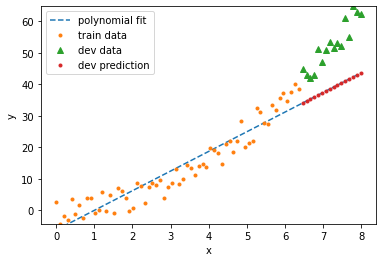

In [12]:
# Define the input to span training and validation sets (excluding test set) - no cheating!
x_c = np.linspace(x[0], np.max(x_dev), 100)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_c, reg.predict(make_features(x_c, degree=d)), '--')
ax.plot(x_train, y_train, '.')
ax.plot(x_dev, y_dev, '^', ms=6)
ax.plot(x_dev, reg.predict(make_features(x_dev, degree=d)), '.')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(np.min(y_train), np.max(y_dev))
ax.legend(['polynomial fit', 'train data', 'dev data', 'dev prediction'])
plt.show()

You can see that the error on the training set is much lower than on the validation set. This is normal, but can we do better on the validation set? Are we overfitting or underfitting? 

Here we're clearly underfitting: the model is too simple. We need to make it a bit more complex. To do that, set $d=2$, and try again. In this case, we know the right answer, but in real-world problems we don't. We'd have to test different inputs $d$ and see which one fits best. That's why automating feature selection and hyperparameter tuning can save you a lot of time. 

To illustrate this point, I'll define functions for splitting the data into train/dev/test sets and printing their error so we can train the model in a loop over different values of the degree $d$.

In [13]:
# Split the data
def split_data(x, y, test_size=0.2, shuffle=False):
    X = make_features(x, degree=d)
    Y = y.reshape(-1, 1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=shuffle)
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=test_size, shuffle=shuffle)
    
    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

# Plot results
def plot_results(x_train, y_train, x_dev, y_dev, reg, d):
    x_c = np.linspace(x[0], np.max(x_dev), 100)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_c, reg.predict(make_features(x_c, degree=d)), '--')
    ax.plot(x_train, y_train, '.')
    ax.plot(x_dev, y_dev, '^', ms=6)
    ax.plot(x_dev, reg.predict(make_features(x_dev, degree=d)), '.')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(np.min(y_train), np.max(y_dev))
    ax.legend(['polynomial fit', 'train data', 'dev data', 'dev prediction'])
    plt.show()


Now we can loop over different values of $d$, pick the best predictor and finally test it on the test set. This is a good illustration of the whole machine learning process.

In practice, you might have to store your trained models (usually on a local drive) because most real-world machine algorithms take a lot of time to train. You don't want to be training the same model multiple times. In this case, the models and data are small so we can afford to simply save them in a list. 


degree = 1
validation score = -2.9798
train score = 0.8958
validation MSE = 204.4169
train MSE = 15.8034


<IPython.core.display.Math object>

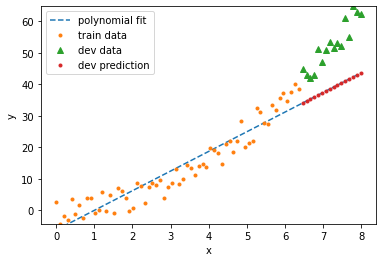


degree = 2
validation score = 0.8218
train score = 0.9512
validation MSE = 9.1537
train MSE = 7.4012


<IPython.core.display.Math object>

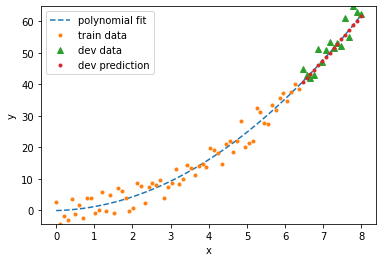


degree = 3
validation score = 0.8222
train score = 0.9518
validation MSE = 9.1300
train MSE = 7.3183


<IPython.core.display.Math object>

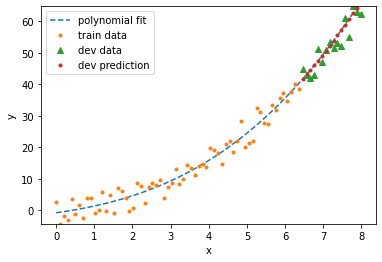


degree = 4
validation score = 0.8458
train score = 0.9518
validation MSE = 7.9198
train MSE = 7.3078


<IPython.core.display.Math object>

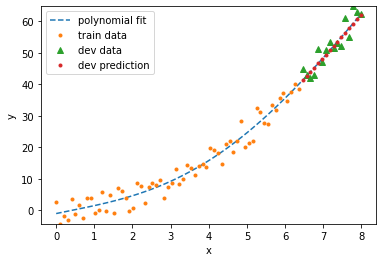


degree = 5
validation score = 0.8333
train score = 0.9518
validation MSE = 8.5608
train MSE = 7.3077


<IPython.core.display.Math object>

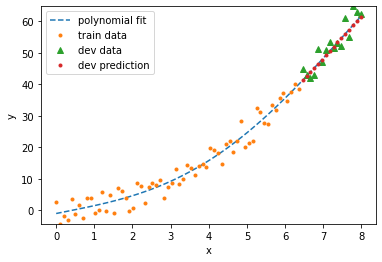


degree = 6
validation score = 0.6219
train score = 0.9518
validation MSE = 19.4231
train MSE = 7.3073


<IPython.core.display.Math object>

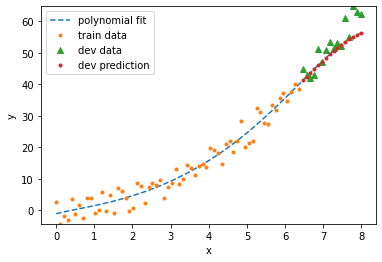

In [14]:
degree_list = [1, 2, 3, 4, 5, 6]

reg_list = []
mse_dev_list = []
score_dev_list = []

for d in degree_list:
    
    # Split data
    X_train, Y_train, X_dev, Y_dev, X_test, Y_test = split_data(x, y)
    
    # Fit model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X_train, Y_train)
    
    # Compute errors
    mse_dev = get_error(x_dev, y_dev, reg, d)
    mse_train = get_error(x_train, y_train, reg, d)
    score_dev = reg.score(X_dev, Y_dev)
    score_train = reg.score(X_train, Y_train)

    # Print the errors
    print('\ndegree = %d'%(d))
    print('validation score = %.4f'%( score_dev ))
    print('train score = %.4f'%( score_train ))
    print('validation MSE = %.4f'%(mse_dev))
    print('train MSE = %.4f'%(mse_train))
    
    # Print model
    display(Math(latexify_predictor(reg.coef_[0])))
    
    # Plot results
    plot_results(x_train, y_train, x_dev, y_dev, reg, d)
    
    # Store results
    reg_list.append(reg)
    mse_dev_list.append(mse_dev)
    score_dev_list.append(score_dev)
    

In [15]:
# Let's see who wins!
best_degree = degree_list[np.argmax(score_dev_list)]
print('best predictor has degree (drum roll)... ', best_degree, '!')

best predictor has degree (drum roll)...  4 !


Clearly, the 6th degree polynomial is over-fitting and the first degree polynomial is under-fitting. But with a large noise magnitude and so little data, it's not clear whether a second order or third order polnomial will do better. When I run the model, sometimes it prefers the polynomial of degree $3$. Conclusion: there's no guarantee that we can even recover the model we used to generate the data! That's a sobering lesson to learn from this example. Machine learning algorithms in general do not always discover the underlying pattern. This is a good analogy to think about even for more complex machine learning models like deep networks.

Before we test our model on the test set, is there something else we can try? Can we do a better job to recover the quadratic model we used to generate the data? Of course! This is where regularization comes in.

Linear predictors are great but they'd be even greater if there is a way we can get them to minimize over-fitting and generalize over the validation set without trying all possible polynomial degrees. To achieve that, we minimize the norm of $\mathbf w$ (by adding it to the original square loss). The $L_1$ norm, $|\mathbf w|$, makes the predictor more sparse (sets small coefficients in the polynomial to zero), while the $L_2$ norm $\| \mathbf  w\|$ makes the predictor less "wiggly" or smoother. Adding a loss term that minimizes the norm is called regularization.

Let's check out what the $L_1$ norm does. In scikit-learn, the function that does that is `Lasso`, and you can find more details about it [here](https://sklearn.org/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso). The syntax is exactly the same as before but replacing `LinearRegression` with `Lasso`


degree = 2
validation score = 0.8501
train score = 0.9508
validation MSE = 7.6975
train MSE = 7.4587


<IPython.core.display.Math object>

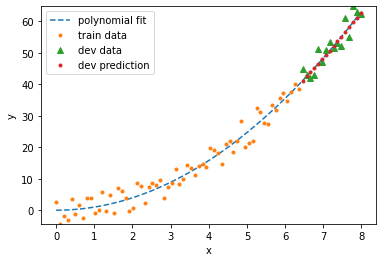

In [16]:
from sklearn.linear_model import Lasso

d = 2

# Split data
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = split_data(x, y)

# Fit model
reg = Lasso(fit_intercept=False)
reg.fit(X_train, Y_train)

# Compute errors
mse_dev = get_error(x_dev, y_dev, reg, d)
mse_train = get_error(x_train, y_train, reg, d)
score_dev = reg.score(X_dev, Y_dev)
score_train = reg.score(X_train, Y_train)

# Print the errors
print('\ndegree = %d'%(d))
print('validation score = %.4f'%( score_dev ))
print('train score = %.4f'%( score_train ))
print('validation MSE = %.4f'%(mse_dev))
print('train MSE = %.4f'%(mse_train))

# Print model
display(Math(latexify_predictor(reg.coef_)))

# Plot results
plot_results(x_train, y_train, x_dev, y_dev, reg, d)

Beautiful! Lasso recovered our model almost perfectly. The motivation for using sparse regularization is Occam's razor: the simplest explanation is usually the right one. The algorithm found that it only needs one term to fit the data, so it set the other terms to zero. This is the power of adding the norm $|\mathbf w|$ to the loss. There's something I ignored when I use Lasso: how of the $L_1$ norm to include. You will see in the documentation that it is set to $1.0$ by default, but in my experience, you'll want to include much less than that to avoid making the model too simple. That's a hyperparameter that you can also loop over and see what works best for your model.

Finally, we can test our model on the test set:


degree = 2
validation score = 0.8501
train score = 0.9508
validation MSE = 7.6975
train MSE = 7.4587


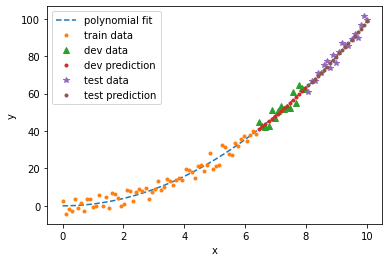

In [17]:
# Print the errors
print('\ndegree = %d'%(d))
print('validation score = %.4f'%( score_dev ))
print('train score = %.4f'%( score_train ))
print('validation MSE = %.4f'%(mse_dev))
print('train MSE = %.4f'%(mse_train))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, reg.predict(make_features(x, degree=d)), '--')
ax.plot(x_train, y_train, '.')
ax.plot(x_dev, y_dev, '^', ms=6)
ax.plot(x_dev, reg.predict(make_features(x_dev, degree=d)), '.')
ax.plot(x_test, y_test, '*', ms=6)
ax.plot(x_test, reg.predict(make_features(x_test, degree=d)), '.')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['polynomial fit', 'train data', 'dev data', 'dev prediction', 'test data', 'test prediction'])
plt.show()

Adding regularization will also prevent higher order polynomials from over-fitting. Lasso might get rid of all other features except the one you need! This is a teaser. Download the code and try it out yourself.

One way of improving your predictions is to add more data. If you go back and set the data input to a 1000, you'll see that your results will be much better. The higher dimensional your feature vector, the more data you need. This is particularly the case with neural networks: those beasts are always data-hungry!